In [1]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML 

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

# Data Description

## Loading Data 

In [2]:
df1 = pd.read_csv('C:/FRAUD.csv')

In [3]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


## Column Rename 

In [5]:
import inflection
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [6]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## Data Dimension

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 6362620
Number of Cols: 11


## Data Types and Structure 

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   name_orig         object 
 4   oldbalance_org    float64
 5   newbalance_orig   float64
 6   name_dest         object 
 7   oldbalance_dest   float64
 8   newbalance_dest   float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Check NA 

In [9]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

# Fill Out NA

There's no NaN values to fill.

## Change Data Type 

I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [10]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})


In [11]:
df1.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,no,no
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,no,no
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,yes,no
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,yes,no
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,no,no


# Description Statistics

In [12]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

Descriptive statistics help us to simplify large amount of data in a sensible way.

# Numerical Attributes

In [13]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe


,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,7.420000e+02,0.584772,0.375177,0.329071
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,9.244552e+07,3.357344,30.993949,1797.956705
oldbalance_org,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,5.958504e+07,3.463606,5.249136,32.964879
newbalance_orig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,4.958504e+07,3.419485,5.176884,32.066985
oldbalance_dest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,3.560159e+08,3.088194,19.921758,948.674125
newbalance_dest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,3.561793e+08,2.999298,19.352302,862.156508


All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

The step variable starts from 1 hour to 925 hour (39 days).

Some variables are higher shap and right skewed.

50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

The skew is higher positive, therefore the values may be in less values.

# Categorical Attributes

In [14]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,6362620,6362620,6362620,6362620,6362620
unique,5,6353307,2722362,2,2
top,CASH_OUT,C1902386530,C1286084959,no,no
freq,2237500,3,113,6354407,6362604


here's a lot of variability in name_orig, so it could be hard to use one hot encoding.

There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# Mind Map

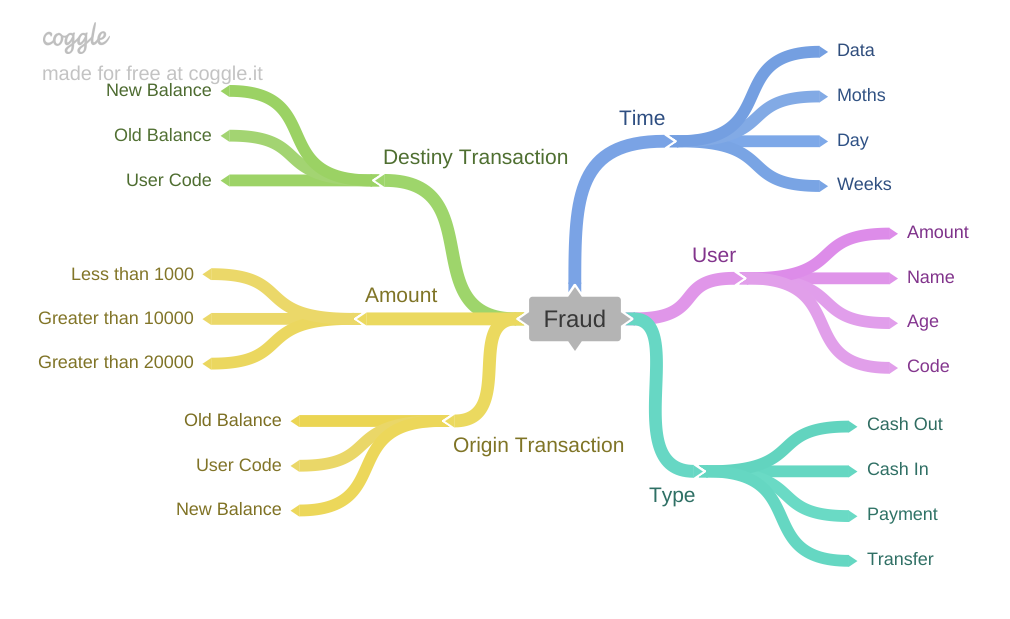

In [15]:
Image('E:/teachable machine/fraud image.png')

In [15]:
df2=df1

# Feature Engineering

In [16]:
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))


df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']


df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']


df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

In [17]:
df1.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,1,PAYMENT,9839.64,C,170136.0,160296.36,M,0.0,0.0,no,no,0.041667,0.005952,-9839.64,0.0
1,1,PAYMENT,1864.28,C,21249.0,19384.72,M,0.0,0.0,no,no,0.041667,0.005952,-1864.28,0.0
2,1,TRANSFER,181.00,C,181.0,0.00,C,0.0,0.0,yes,no,0.041667,0.005952,-181.00,0.0
3,1,CASH_OUT,181.00,C,181.0,0.00,C,21182.0,0.0,yes,no,0.041667,0.005952,-181.00,-21182.0
4,1,PAYMENT,11668.14,C,41554.0,29885.86,M,0.0,0.0,no,no,0.041667,0.005952,-11668.14,0.0


# Selecting Columns

In [18]:
df3=df2

Selecting Columns

I will use all the columns for data analysis

Selecting Lines

I will use all the lines

# Exploratory Data Analisys


In [19]:
df4=df3

# Univariate Analysis

## Response Variable 

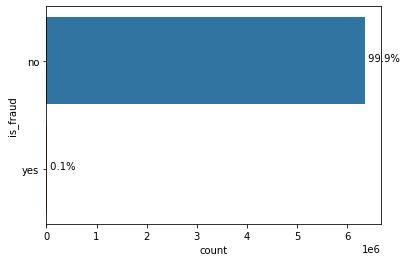

In [21]:
ax = sns.countplot(y='is_fraud', data=df4);

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

# Numerical Variables

## Categorical Variables 

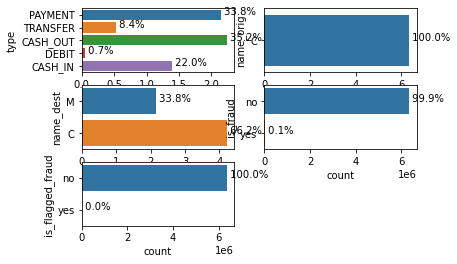

In [22]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1


# Bivariate Analysis

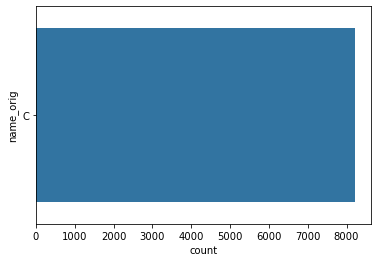

In [23]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1);

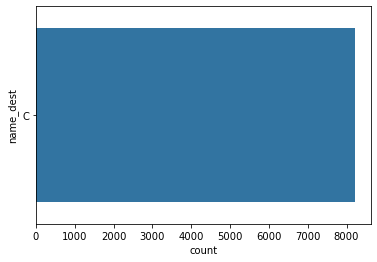

In [24]:
sns.countplot(y='name_dest', data=aux1);

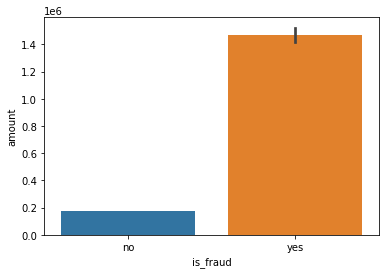

In [25]:
sns.barplot(y='amount', x='is_fraud', data=df4);

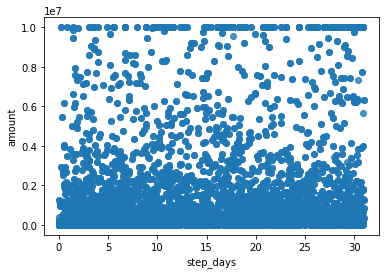

In [26]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

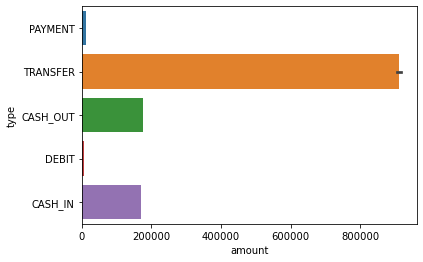

In [27]:
ax = sns.barplot(y='type', x='amount', data=df4);

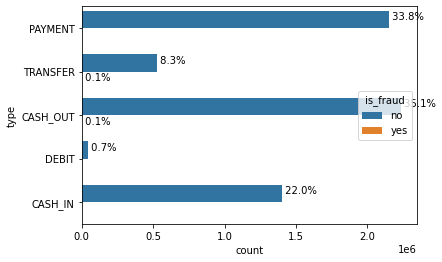

In [28]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)
total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

# Multivariaty Analysis

## Numerical Analysis 

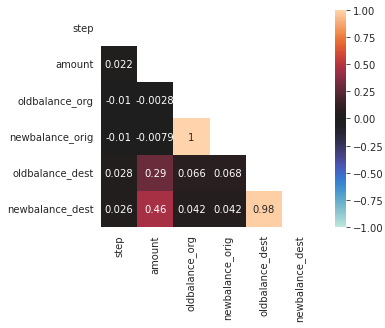

In [29]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

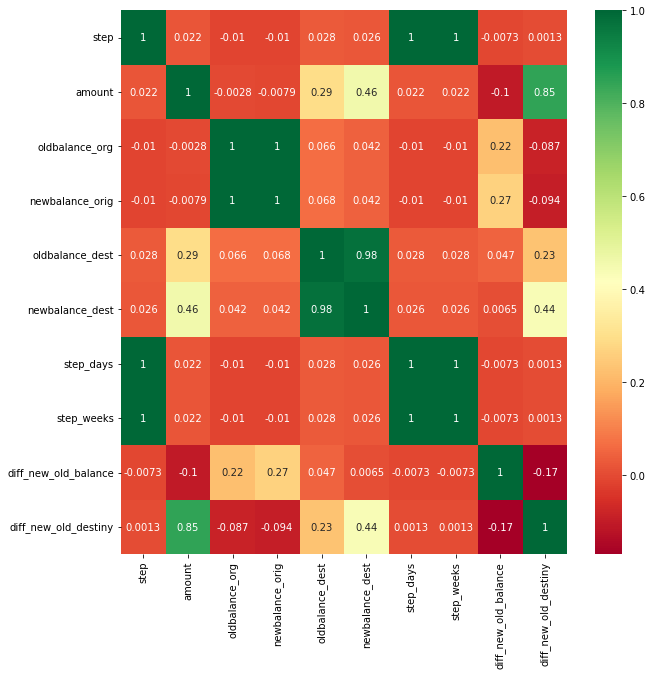

In [30]:
corrmat = df4.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(df4[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Data Preparation

In [20]:
df5=df4

## Spliting into Train, Valid and Test

In [21]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest', 
                      'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [22]:
X

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,-9839.64,0.00
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,-1864.28,0.00
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,-181.00,0.00
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,-181.00,-21182.00
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,-11668.14,0.00
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,-339682.13,339682.13
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,-6311409.28,0.00
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,-6311409.28,6311409.27
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,-850002.52,0.00


In [23]:
y

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: is_fraud, Length: 6362620, dtype: int64

In [24]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

# One Hot Encoder

In [26]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

# Rescaling

In [27]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [28]:
final_columns_selected = ['step', 'oldbalance_org', 
                          'newbalance_orig', 'newbalance_dest', 
                          'diff_new_old_balance', 'diff_new_old_destiny', 
                          'type_TRANSFER']

In [29]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# Machine Learning Modeling

In [30]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [31]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

# Logistic Regression

In [43]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.642,0.959,0.284,0.438,0.438


# Classification Report

In [45]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.96      0.28      0.44      1314

    accuracy                           1.00   1018020
   macro avg       0.98      0.64      0.72   1018020
weighted avg       1.00      1.00      1.00   1018020



## Cross Validation

In [33]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.655 +/- 0.007,0.955 +/- 0.005,0.31 +/- 0.013,0.468 +/- 0.015,0.468 +/- 0.015


# K Nearest Neighbors

In [46]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [47]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.739,0.989,0.478,0.644,0.644


# Classification Report

In [48]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.99      0.48      0.64      1314

    accuracy                           1.00   1018020
   macro avg       0.99      0.74      0.82   1018020
weighted avg       1.00      1.00      1.00   1018020



## Cross Validation 

In [ ]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp_cs, y_temp)
knn_cv

Fold K=1


# Random Forest

In [36]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [37]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.892,0.981,0.785,0.872,0.872


## Classification Report 

In [38]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.98      0.78      0.87      1314

    accuracy                           1.00   1018020
   macro avg       0.99      0.89      0.94   1018020
weighted avg       1.00      1.00      1.00   1018020



## Cross Validation 

In [33]:
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.895 +/- 0.004,0.974 +/- 0.004,0.791 +/- 0.008,0.873 +/- 0.004,0.873 +/- 0.004


#  XGBoost

In [32]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [33]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.925,0.977,0.85,0.909,0.909


## Classification Report 

In [34]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.98      0.85      0.91      1314

    accuracy                           1.00   1018020
   macro avg       0.99      0.93      0.95   1018020
weighted avg       1.00      1.00      1.00   1018020



## Cross Validation 

In [32]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.925 +/- 0.009,0.976 +/- 0.003,0.851 +/- 0.018,0.909 +/- 0.01,0.909 +/- 0.01


In [33]:
f1 = make_scorer(f1_score)

In [34]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}